In [1]:
from training_defs import load_data, train_model


#Loading training, validating, testing data sets
train_loader, val_loader, test_loader, scaler = load_data(
    csv_path="simpler_data_rwc.csv",
    test_size=0.2,    # 20% for validation
    batch_size=32     # Process 32 samples at a time
    )
dataset_size = len(train_loader) + len(val_loader)+len(test_loader)
print(f"Training: {len(train_loader)/dataset_size * 100:.2f}%")
print(f"Validating: {len(val_loader)/dataset_size * 100:.2f}%")
print(f"Testing: {len(test_loader)/dataset_size * 100:.2f}%")


Training: 78.57%
Validating: 10.71%
Testing: 10.71%


Training MLP: 210 → 64 → 3 fractions
Epoch  1: Train=0.1139, Val=0.0464
Epoch  2: Train=0.0448, Val=0.0434


C:\Users\xdark\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:1340: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  current = float(metrics)


Epoch  3: Train=0.0405, Val=0.0322
Epoch  4: Train=0.0365, Val=0.0307
Epoch  5: Train=0.0335, Val=0.0241
Epoch  6: Train=0.0304, Val=0.0228
Epoch  7: Train=0.0262, Val=0.0237
Epoch  8: Train=0.0276, Val=0.0234
Epoch  9: Train=0.0305, Val=0.0246
Epoch 10: Train=0.0316, Val=0.0275
Epoch 11: Train=0.0246, Val=0.0206
Epoch 12: Train=0.0293, Val=0.0228
Epoch 13: Train=0.0258, Val=0.0215
Epoch 14: Train=0.0270, Val=0.0181
Epoch 15: Train=0.0218, Val=0.0182
Epoch 16: Train=0.0259, Val=0.0200
Epoch 17: Train=0.0227, Val=0.0195
Epoch 18: Train=0.0241, Val=0.0181
Epoch 19: Train=0.0214, Val=0.0182
Epoch 20: Train=0.0234, Val=0.0204
Epoch 21: Train=0.0253, Val=0.0173
Epoch 22: Train=0.0235, Val=0.0169
Epoch 23: Train=0.0206, Val=0.0184
Epoch 24: Train=0.0202, Val=0.0194
Epoch 25: Train=0.0208, Val=0.0171
Epoch 26: Train=0.0249, Val=0.0210
Epoch 27: Train=0.0224, Val=0.0157
Epoch 28: Train=0.0203, Val=0.0214
Epoch 29: Train=0.0234, Val=0.0177
Epoch 30: Train=0.0218, Val=0.0179
Epoch 31: Train=0.02

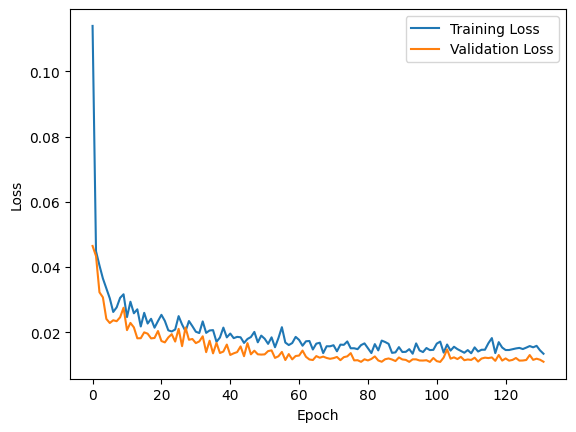

In [2]:
import matplotlib.pyplot as plt
from training_defs import train_model

# Use your current parameters - the logic is now fixed!
model, scaler, losses = train_model(
    input_size=210,      # Match your data
    hidden_size=64,      # Your current size
    learning_rate=0.01, # Your current rate
    num_epochs=200,       # More epochs since learning was broken before
    patience=30
)

plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [3]:
# Cell 3: Comprehensive Model Evaluation
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from model import MLP
from training_defs import load_data

# Load the trained model
model = MLP(input_size=210, hidden_size=64, dropout_rate=0.2)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Get test data (IMPORTANT: Use test set, not validation!)
_, _, test_loader, _ = load_data()  # Get test_loader

# Collect all predictions and targets
all_predictions = []
all_targets = []

with torch.no_grad():
    for X, y in test_loader:
        pred = model(X)
        all_predictions.append(pred.numpy())
        all_targets.append(y.numpy())

# Concatenate all batches
y_pred = np.concatenate(all_predictions, axis=0)
y_true = np.concatenate(all_targets, axis=0)

# Calculate metrics for each vegetation fraction
fraction_names = ['Green Vegetation (GV)', 'Non-Photosynthetic Vegetation (NPV)', 'Soil']

print("📊 Model Evaluation Results:")
print("=" * 50)

for i, name in enumerate(fraction_names):
    mse = mean_squared_error(y_true[:, i], y_pred[:, i])
    mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true[:, i], y_pred[:, i])
    
    print(f"\n{name}:")
    print(f"  MSE:  {mse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²:   {r2:.4f}")

# Overall metrics (averaged across all fractions)
overall_mse = mean_squared_error(y_true, y_pred)
overall_mae = mean_absolute_error(y_true, y_pred)
overall_r2 = r2_score(y_true, y_pred)

print(f"\n{'Overall (All Fractions)':}")
print(f"  MSE:  {overall_mse:.4f}")
print(f"  MAE:  {overall_mae:.4f}")
print(f"  R²:   {overall_r2:.4f}")


📊 Model Evaluation Results:

Green Vegetation (GV):
  MSE:  0.0107
  MAE:  0.0774
  RMSE: 0.1033
  R²:   0.8734

Non-Photosynthetic Vegetation (NPV):
  MSE:  0.0142
  MAE:  0.0934
  RMSE: 0.1190
  R²:   0.8393

Soil:
  MSE:  0.0078
  MAE:  0.0598
  RMSE: 0.0883
  R²:   0.9327

Overall (All Fractions)
  MSE:  0.0109
  MAE:  0.0769
  R²:   0.8818
